# SpectralNET Exploring Spatial Spectral Wavelet CNN for Hyper Spectral Image Classification

**Authors:** Tanmay CHAKRABORTY and Utkarsh TREHAN

In [1]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from tensorflow.keras import backend as Kb
from keras.layers import Lambda
from keras.layers import Activation
from keras.layers import add, concatenate
from keras.layers import AveragePooling2D
from keras.utils import plot_model
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
 
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from operator import truediv
 
from plotly.offline import init_notebook_mode
 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
!pip install spectral
import spectral

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import AveragePooling3D

2024-07-15 11:41:17.854530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 11:41:17.882413: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 11:41:17.882458: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 11:41:17.903047: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 11:41:18.941526: W tensorflow/com


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
def applyFA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    fa = FactorAnalysis(n_components=numComponents, random_state=0)
    newX = fa.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, fa
    

In [3]:
# def applyPCA(X, numComponents=75):
#     newX = np.reshape(X, (-1, X.shape[2]))
#     pca = PCA(n_components=numComponents, whiten=True)
#     newX = pca.fit_transform(newX)
#     newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
#     return newX, pca

In [4]:
## GLOBAL VARIABLES
dataset = 'PU'
test_ratio = 0.95
windowSize = 12

In [5]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    elif name == 'HSN':
        data = sio.loadmat(os.path.join(data_path, '2013_IEEE_GRSS_DF_Contest_CASI_349_1905_144.mat'))['ans']
        labels = sio.loadmat(os.path.join(data_path, 'GRSS2013.mat'))['name']
    return data, labels

In [6]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [7]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [8]:
def createImageCubes(X, y, windowSize=8, removeZeroLabels = True):
    margin = int((windowSize) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin , c - margin:c + margin ]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [9]:
X, y = loadData(dataset)

X.shape, y.shape

((610, 340, 103), (610, 340))

In [10]:
K = X.shape[2]

In [11]:
K = 3 if dataset == 'IP' else 3
X,fa = applyFA(X,numComponents=K)

X.shape

(610, 340, 3)

In [12]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((42776, 12, 12, 3), (42776,))

In [13]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((2138, 12, 12, 3), (40638, 12, 12, 3), (2138,), (40638,))

In [14]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(2138, 12, 12, 3, 1)

In [15]:
ytrain = to_categorical(ytrain)
ytrain.shape

(2138, 9)

In [16]:
S1 = windowSize
L1 = K
if (dataset == 'PU'):
    output_units = 9
elif (dataset == 'HSN'):
    output_units = 15
else:
    output_units = 16

In [17]:
def get_wavelet_cnn_model():
 
    input_shape =  (12, 12, 3)
 
    input_ = Input(input_shape, name='the_input')
    
    # Reshape input to 3D
    reshaped_input = Reshape((12, 12, 3, 1))(input_)

    # Level one decomposition
    conv_1 = Conv3D(64, kernel_size=(3, 3, 3), padding='same', name='conv_1')(reshaped_input)
    norm_1 = BatchNormalization(name='norm_1')(conv_1)
    relu_1 = Activation('relu', name='relu_1')(norm_1)

    conv_1_2 = Conv3D(64, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same', name='conv_1_2')(relu_1)
    norm_1_2 = BatchNormalization(name='norm_1_2')(conv_1_2)
    relu_1_2 = Activation('relu', name='relu_1_2')(norm_1_2)

    # Level two decomposition
    conv_2 = Conv3D(128, kernel_size=(3, 3, 3), padding='same', name='conv_2')(relu_1_2)
    norm_2 = BatchNormalization(name='norm_2')(conv_2)
    relu_2 = Activation('relu', name='relu_2')(norm_2)

    conv_2_2 = Conv3D(128, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same', name='conv_2_2')(relu_2)
    norm_2_2 = BatchNormalization(name='norm_2_2')(conv_2_2)
    relu_2_2 = Activation('relu', name='relu_2_2')(norm_2_2)

    # Level three decomposition
    conv_3 = Conv3D(256, kernel_size=(3, 3, 3), padding='same', name='conv_3')(relu_2_2)
    norm_3 = BatchNormalization(name='norm_3')(conv_3)
    relu_3 = Activation('relu', name='relu_3')(norm_3)

    conv_3_2 = Conv3D(256, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same', name='conv_3_2')(relu_3)
    norm_3_2 = BatchNormalization(name='norm_3_2')(conv_3_2)
    relu_3_2 = Activation('relu', name='relu_3_2')(norm_3_2)

    # Level four decompositionoutput_layer = build_model(flatten_layer.shape[1:], hidden_dim, output_dim, delta_param_init, num_classes)(flatten_layer
    conv_4 = Conv3D(256, kernel_size=(3, 3, 3), padding='same', name='conv_4')(relu_3_2)
    norm_4 = BatchNormalization(name='norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(norm_4)

    conv_4_2 = Conv3D(256, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same', name='conv_4_2')(relu_4)
    norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
    relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)

    # Classification head
    conv_5_1 = Conv3D(128, kernel_size=(3, 3, 3), padding='same', name='conv_5_1')(relu_4_2)
    norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
    relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)
    
    pool_5_1 = AveragePooling3D(pool_size=(2, 2, 2), strides=(1, 1, 1), padding='same', name='avg_pool_5_1')(relu_5_1)
    flatten_layer = Flatten()(pool_5_1)

    num_classes = output_units
    output_layer = Dense(num_classes, activation='softmax')(flatten_layer)
    
    model = Model(inputs=input_, outputs=output_layer)
    model.summary()
    return model

In [18]:
model = get_wavelet_cnn_model()

2024-07-15 11:43:34.866203: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7034 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:73:00.0, compute capability: 6.1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ the_input (InputLayer)          │ (None, 12, 12, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 12, 12, 3, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv3D)                 │ (None, 12, 12, 3, 64)  │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_1 (BatchNormalization)     │ (None, 12, 12, 3, 64)  │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1 (Activation)             │ (None, 12, 12, 3, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_2 (Conv3D)               │ (None, 6, 6, 2, 64)    │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_1_2 (BatchNormalization)   │ (None, 6, 6, 2, 64)    │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1_2 (Activation)           │ (None, 6, 6, 2, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv3D)                 │ (None, 6, 6, 2, 128)   │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_2 (BatchNormalization)     │ (None, 6, 6, 2, 128)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_2 (Activation)             │ (None, 6, 6, 2, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_2 (Conv3D)               │ (None, 3, 3, 1, 128)   │       442,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_2_2 (BatchNormalization)   │ (None, 3, 3, 1, 128)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_2_2 (Activation)           │ (None, 3, 3, 1, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv3D)                 │ (None, 3, 3, 1, 256)   │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_3 (BatchNormalization)     │ (None, 3, 3, 1, 256)   │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_3 (Activation)             │ (None, 3, 3, 1, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3_2 (Conv3D)               │ (None, 2, 2, 1, 256)   │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_3_2 (BatchNormalization)   │ (None, 2, 2, 1, 256)   │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_3_2 (Activation)           │ (None, 2, 2, 1, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv3D)                 │ (None, 2, 2, 1, 256)   │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_4 (BatchNormalization)     │ (None, 2, 2, 1, 256)   │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_4 (Activation)             │ (None, 2, 2, 1, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4_2 (Conv3D)               │ (None, 1, 1, 1, 256)   │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_4_2 (BatchNormalization)   │ (None, 1, 1, 1, 256)   │         1,02

 Total params: 7,862,601 (29.99 MB)

 Trainable params: 7,859,529 (29.98 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [19]:
#adam = Adam(lr=0.001, decay=1e-06)
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [20]:
filepath = "best-model_PU_3DCNN_HSI.keras"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

In [21]:
import time  

In [22]:
start_time = time.time()

history = model.fit(x=Xtrain, y=ytrain, batch_size = 32, epochs=50, callbacks=callbacks_list)

end_time = time.time()  
total_time = end_time - start_time  
print(f'Finished training. Total training time: {total_time:.2f} seconds')  # Print the total training time

Epoch 1/50


I0000 00:00:1721024018.221866   97422 service.cc:145] XLA service 0x741878018ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721024018.221939   97422 service.cc:153]   StreamExecutor device (0): Quadro P4000, Compute Capability 6.1
2024-07-15 11:43:38.302709: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-15 11:43:38.596006: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 9/67 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4605 - loss: 1.7806

I0000 00:00:1721024022.424905   97422 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6303 - loss: 1.1100
Epoch 1: saving model to best-model_PU_3DCNN_HSI.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.6314 - loss: 1.1052
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7932 - loss: 0.5168
Epoch 2: saving model to best-model_PU_3DCNN_HSI.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7935 - loss: 0.5165
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8408 - loss: 0.3899
Epoch 3: saving model to best-model_PU_3DCNN_HSI.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8411 - loss: 0.3895
Epoch 4/50
64/67 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8883 - loss: 0.3231
Epoch 4: saving model to best-model_PU_3DCNN_HSI.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8879 - loss: 0.3242
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8962 - loss: 0.2546
Epoch 5: saving model to best-model_PU_3DCNN_HSI.keras
67/67 ━━━━━━━━

# Validation

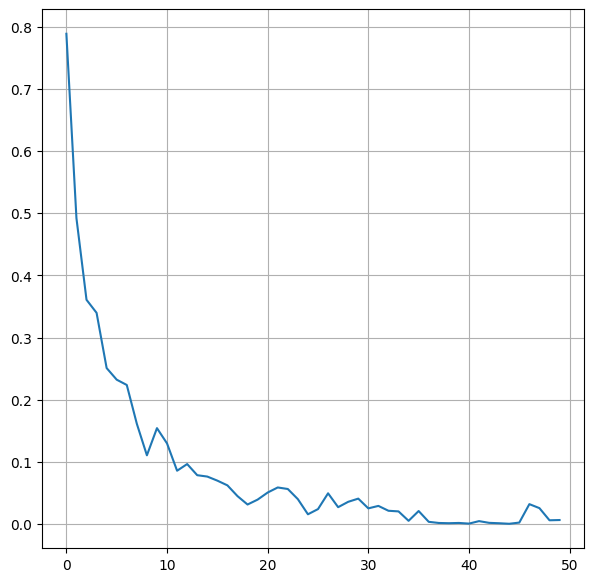

In [23]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.ylabel('Loss') 
#plt.xlabel('Epochs') 
#plt.legend(['Training','Validation'], loc='upper right') 
#plt.savefig("loss_curve.pdf") 
#plt.show()
#plt.figure(figsize=(5,5)) 
#plt.ylim(0,1.1) 
#plt.grid() 
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.ylabel('Accuracy') 
#plt.xlabel('Epochs') 
#plt.legend(['Training','Validation']) 
#plt.savefig("acc_curve.pdf") 
#plt.show()

In [24]:
# load best weights
model.load_weights("best-model_PU_3DCNN_HSI.keras")
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [25]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(40638, 12, 12, 3, 1)

In [26]:
ytest = to_categorical(ytest)
ytest.shape

(40638, 9)

In [27]:
start_time = time.time()

Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

end_time = time.time()  # End timing
test_time = end_time - start_time  # Calculate the test time
print(f'Test time: {test_time:.2f} seconds')

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

1270/1270 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step
Test time: 12.88 seconds
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6299
           1       0.99      0.98      0.99     17717
           2       0.93      0.96      0.95      1994
           3       0.99      0.99      0.99      2911
           4       1.00      1.00      1.00      1278
           5       0.94      0.97      0.95      4778
           6       0.99      0.96      0.97      1263
           7       0.97      0.97      0.97      3498
           8       0.98      1.00      0.99       900

    accuracy                           0.98     40638
   macro avg       0.97      0.98      0.98     40638
weighted avg       0.98      0.98      0.98     40638



In [28]:
# Overall Accuracy
oa = accuracy_score(np.argmax(ytest, axis=1), y_pred_test)

# Confusion Matrix
cm = confusion_matrix(np.argmax(ytest, axis=1), y_pred_test)
# Calculate per-class accuracy from the confusion matrix
class_accuracy = cm.diagonal() / cm.sum(axis=1)
# Average Accuracy
aa = np.mean(class_accuracy)

# Kappa Coefficient
kappa = cohen_kappa_score(np.argmax(ytest, axis=1), y_pred_test)

print(f'Overall Accuracy (OA): {oa:.4f}')
print(f'Average Accuracy (AA): {aa:.4f}')
print(f'Kappa Coefficient: {kappa:.4f}')
for i, acc in enumerate(class_accuracy): print(f'Class {i+1} Accuracy: {acc:.4f}')

Overall Accuracy (OA): 0.9776
Average Accuracy (AA): 0.9780
Kappa Coefficient: 0.9703
Class 1 Accuracy: 0.9760
Class 2 Accuracy: 0.9813
Class 3 Accuracy: 0.9649
Class 4 Accuracy: 0.9876
Class 5 Accuracy: 1.0000
Class 6 Accuracy: 0.9663
Class 7 Accuracy: 0.9612
Class 8 Accuracy: 0.9683
Class 9 Accuracy: 0.9967


In [29]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [30]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [31]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)

1270/1270 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9781 - loss: 0.0820


In [32]:
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [33]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [34]:
# load the original image
X, y = loadData(dataset)

In [35]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize

In [36]:
K = 3
X,fa = applyFA(X, numComponents=K)



KeyboardInterrupt



In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [ ]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)